# Introduction

In this notebook we develop a Multi Agent Deep Deterministic Policy Gradient (MADDPG) model and analyse its performance on Unity's Tennis environment with two agents. We also develop and analyse its performance with Noisy Nets and PER.

This is part of the third and last project: *Collaboration and Competition* in **Deep Reinforcement Learning for Enterprise** Course at *Udacity*.

## 0 - Importing Packages

Importing all required packages, utilities and initialising the environment.

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from training_maddpg_cl_ee import maddpg
from maddpg_cl_ee import Team

def maxlen(dic):
    l = 0
    for e in dic.values():
        if len(e) > l:
            l = len(e)
    return l

def dic_fix(dic):
    dicF = {}
    ml = maxlen(dic)
    for i , e in enumerate(dic.values()):
        new = [None] * (ml - len(e))
        dicF[i] = e + new
    return dicF

env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 1 - Training a MADDPG model

Defining a dictionary with all hyperparameters inputs in the learning model. Using the values mentioned in the Results section of Barth-Maron's paper.

In [6]:
dic = {'n_episodes': 25000,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 256,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0,           # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.9,              # uniform noise process initial scale parameter
       'epsilon_halflife': 500,     # no episodes to achieve half of the noise
       'collaboration_level': 0,    # level at which agents share rewards
       'energy_expenditure': 0.000,  # cost of making a move
       'file': 'chpt_maddpg'}       # file name to save agent's net weights

In [7]:
scores_dic = {}
times_dic = {}

for i in range(1):
    print('\nTraining session:\t' + str(i+1))
    scores, times = maddpg(env, dic, SuccessStop=True, NoiseNet=False, PER=False)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_maddpg_analysis.csv')
times_df.to_csv('times_maddpg_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.00	Time Split: 55.43					 
Episode 200	Average Score: 0.00	Time Split: 76.47					 
Episode 300	Average Score: 0.00	Time Split: 68.85					 
Episode 400	Average Score: 0.00	Time Split: 67.40					 
Episode 500	Average Score: 0.00	Time Split: 71.57					 
Episode 600	Average Score: 0.01	Time Split: 73.62					 
Episode 700	Average Score: 0.01	Time Split: 75.76					 
Episode 800	Average Score: 0.01	Time Split: 75.94					 
Episode 900	Average Score: 0.03	Time Split: 89.13					 
Episode 1000	Average Score: 0.03	Time Split: 97.31					 
Episode 1100	Average Score: 0.03	Time Split: 92.91					 
Episode 1200	Average Score: 0.03	Time Split: 93.13					 
Episode 1300	Average Score: 0.03	Time Split: 100.82					 
Episode 1400	Average Score: 0.04	Time Split: 104.21					 
Episode 1500	Average Score: 0.04	Time Split: 111.85					 
Episode 1600	Average Score: 0.05	Time Split: 110.96					 
Episode 1700	Average Score: 0.04	Time Split: 113.11					 
Episode 1800	A

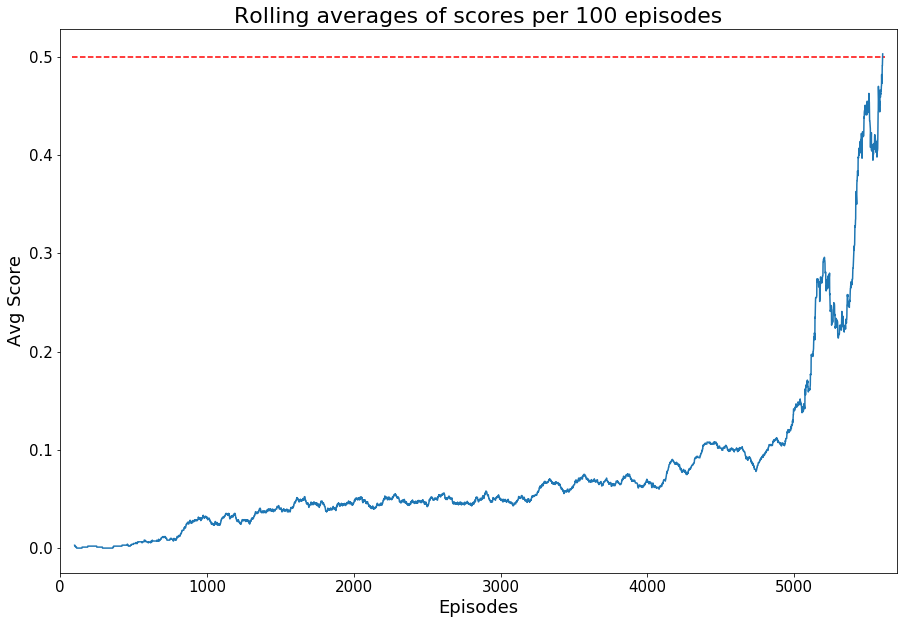

In [8]:
scores_df = pd.read_csv('scores_maddpg_analysis.csv',index_col=0)
times_df = pd.read_csv('times_maddpg_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,5700), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5620, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgMADDPG.png")

In [9]:
rolling.describe()

,0
count,5504.000000
mean,0.076511
std,0.085221
min,0.000000
25%,0.038700
50%,0.050300
75%,0.080425
max,0.503000


The MADDPG model **solved the environment in 5,503 episodes**. Relative high variance of 0.09 with a few drops in growth path throughout the process.

## 2 - Training a MADDPG model with Noisy Nets

We now use a MADDPG model with Noisy Nets using the same hyperparameters as D3PG with Noisy Nets in the previous notebook.

* higher initial error than D3PG model with Noisy Nets.

In [4]:
dic = {'n_episodes': 25000,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0.000001,    # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.05,              # uniform noise process initial scale parameter
       'epsilon_halflife': 200,     # no episodes to achieve half of the noise
       'collaboration_level': 0,    # level at which agents share rewards
       'energy_expenditure': 0.000,  # cost of making a move
       'file': 'chpt_maddpg_nn'}     # file name to save agent's net weights

In [5]:
scores_dic = {}
times_dic = {}

for i in range(1):
    print('\nTraining session:\t' + str(i+1))
    scores, times = maddpg(env, dic, SuccessStop=True, NoiseNet=True, PER=False)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_maddpg_nn_analysis.csv')
times_df.to_csv('times_maddpg_nn_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.01	Time Split: 103.57					 
Episode 200	Average Score: 0.00	Time Split: 136.33					 
Episode 300	Average Score: 0.00	Time Split: 136.30					 
Episode 400	Average Score: 0.02	Time Split: 166.56					 
Episode 500	Average Score: 0.04	Time Split: 192.34					 
Episode 600	Average Score: 0.03	Time Split: 165.60					 
Episode 700	Average Score: 0.04	Time Split: 180.40					 
Episode 800	Average Score: 0.03	Time Split: 180.26					 
Episode 900	Average Score: 0.04	Time Split: 200.46					 
Episode 1000	Average Score: 0.05	Time Split: 228.98					 
Episode 1100	Average Score: 0.03	Time Split: 183.90					 
Episode 1200	Average Score: 0.03	Time Split: 192.70					 
Episode 1300	Average Score: 0.05	Time Split: 229.65					 
Episode 1400	Average Score: 0.05	Time Split: 234.55					 
Episode 1500	Average Score: 0.05	Time Split: 244.69					 
Episode 1600	Average Score: 0.06	Time Split: 276.30					 
Episode 1700	Average Score: 0.05	Time Split: 273.49					 
Ep

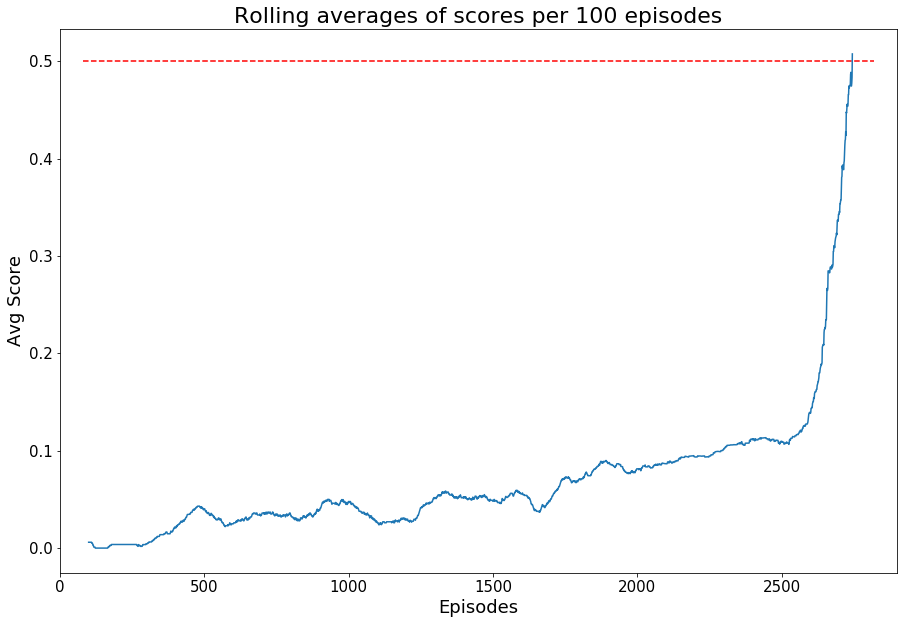

In [10]:
scores_df = pd.read_csv('scores_maddpg_nn_analysis.csv',index_col=0)
times_df = pd.read_csv('times_maddpg_nn_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,2900), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=2820, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgMADDPGNN.png")

In [11]:
rolling.describe()

,0
count,2647.000000
mean,0.067907
std,0.068144
min,0.000000
25%,0.032000
50%,0.050000
75%,0.087700
max,0.507400


The MADDPG model with Noisy Nets **solved the environment in 2,646 episodes**. Lower variance 0.07 and great sustainable growth path passed the 0.1 score mark.

## 3 - Training a MADDPG model with PER

Defining a dictionary with all hyperparameters inputs in the learning model. Using the values from D3PG model with PER.

In [2]:
dic = {'n_episodes': 25000,         # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0,           # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.9,              # uniform noise process initial scale parameter
       'epsilon_halflife': 300,     # no episodes to achieve half of the noise
       'collaboration_level': 0,    # level at which agents share rewards
       'energy_expenditure': 0.000,  # cost of making a move
       'file': 'chpt_maddpg_per'}    # file name to save agent's net weights

In [3]:
scores_dic = {}
times_dic = {}

for i in range(1):
    print('\nTraining session:\t' + str(i+1))
    scores, times = maddpg(env, dic, SuccessStop=True, NoiseNet=False, PER=True)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_maddpg_per_analysis.csv')
times_df.to_csv('times_maddpg_per_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.01	Time Split: 126.22			 
Episode 200	Average Score: 0.00	Time Split: 152.58			 
Episode 300	Average Score: 0.00	Time Split: 148.98			 
Episode 400	Average Score: 0.01	Time Split: 170.22			 
Episode 500	Average Score: 0.03	Time Split: 197.92			 
Episode 600	Average Score: 0.02	Time Split: 187.59			 
Episode 700	Average Score: 0.01	Time Split: 177.00			 
Episode 800	Average Score: 0.01	Time Split: 165.17			 
Episode 900	Average Score: 0.01	Time Split: 172.01			 
Episode 1000	Average Score: 0.01	Time Split: 168.80			 
Episode 1100	Average Score: 0.01	Time Split: 181.35			 
Episode 1200	Average Score: 0.01	Time Split: 166.03			 
Episode 1300	Average Score: 0.03	Time Split: 224.25			 
Episode 1400	Average Score: 0.05	Time Split: 249.94			 
Episode 1500	Average Score: 0.03	Time Split: 201.30			 
Episode 1600	Average Score: 0.03	Time Split: 205.41			 
Episode 1700	Average Score: 0.04	Time Split: 230.09			 
Episode 1800	Average Score: 0.04	Tim

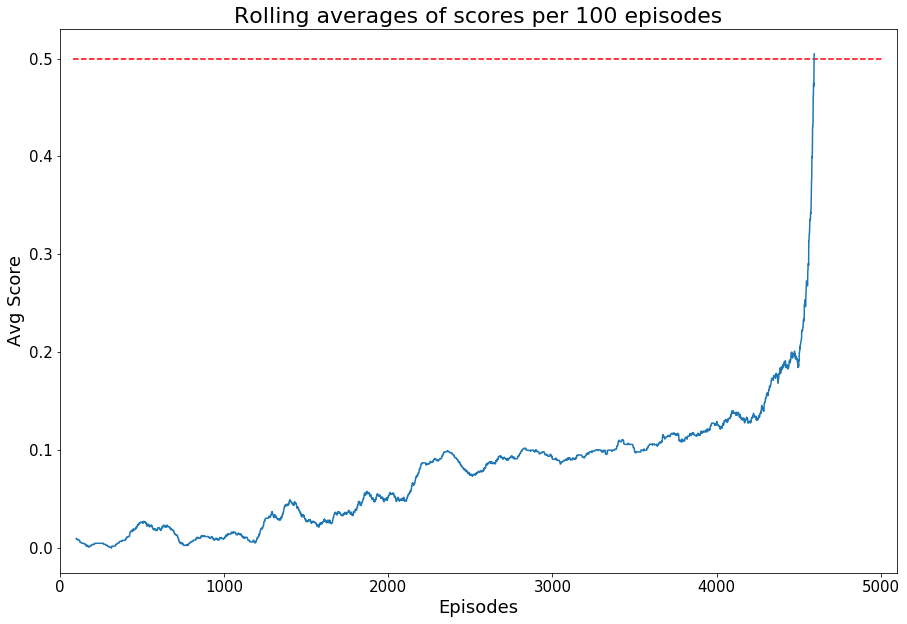

In [4]:
scores_df = pd.read_csv('scores_maddpg_per_analysis.csv',index_col=0)
times_df = pd.read_csv('times_maddpg_per_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,5100), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgMADDPGPER.png")

In [5]:
rolling.describe()

,0
count,4497.000000
mean,0.074354
std,0.058657
min,0.000000
25%,0.025000
50%,0.083800
75%,0.102000
max,0.504700


The MADDPG model with PER **solved the environment in 4,496 episodes**. Very low variance 0.06 and great sustainable growth path passed the 0.2 score mark.

## 4 - Training a MADDPG model with Noisy Nets and PER

In [2]:
dic = {'n_episodes': 10000,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0.000001,    # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.05,              # uniform noise process initial scale parameter
       'epsilon_halflife': 200,     # no episodes to achieve half of the noise
       'collaboration_level': 0,    # level at which agents share rewards
       'energy_expenditure': 0.000,  # cost of making a move
       'file': 'chpt_maddpg_nn_per'}     # file name to save agent's net weights

In [3]:
scores_dic = {}
times_dic = {}

for i in range(1):
    print('\nTraining session:\t' + str(i+1))
    scores, times = maddpg(env, dic, SuccessStop=True, NoiseNet=True, PER=True)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_maddpg_nn_per_analysis.csv')
times_df.to_csv('times_maddpg_nn_per_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.01	Time Split: 128.19					 
Episode 200	Average Score: 0.00	Time Split: 167.24					 
Episode 300	Average Score: 0.00	Time Split: 165.60					 
Episode 400	Average Score: 0.00	Time Split: 166.12					 
Episode 500	Average Score: 0.00	Time Split: 166.68					 
Episode 600	Average Score: 0.00	Time Split: 166.85					 
Episode 700	Average Score: 0.00	Time Split: 167.27					 
Episode 800	Average Score: 0.00	Time Split: 167.51					 
Episode 900	Average Score: 0.00	Time Split: 167.53					 
Episode 1000	Average Score: 0.00	Time Split: 167.73					 
Episode 1100	Average Score: 0.00	Time Split: 170.51					 
Episode 1200	Average Score: 0.00	Time Split: 172.79					 
Episode 1300	Average Score: 0.00	Time Split: 180.30					 
Episode 1400	Average Score: 0.00	Time Split: 180.99					 
Episode 1500	Average Score: 0.00	Time Split: 176.93					 
Episode 1600	Average Score: 0.00	Time Split: 179.67					 
Episode 1700	Average Score: 0.00	Time Split: 184.11					 
Ep

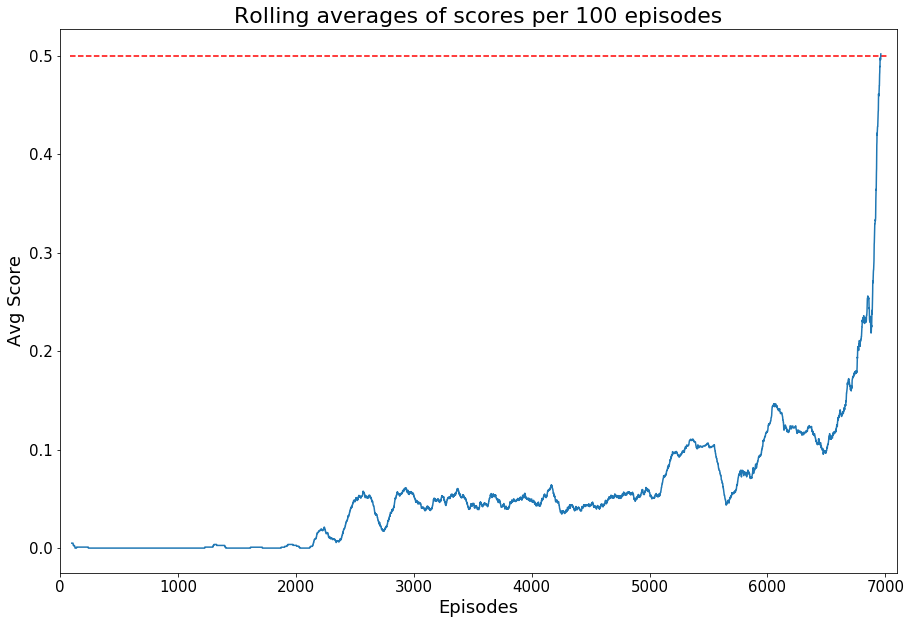

In [13]:
scores_df = pd.read_csv('scores_maddpg_nn_per_analysis.csv',index_col=0)
times_df = pd.read_csv('times_maddpg_nn_per_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,7100), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=7020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgMADDPGNNPER.png")

In [14]:
rolling.describe()

,0
count,6864.000000
mean,0.052976
std,0.059950
min,0.000000
25%,0.001000
50%,0.045900
75%,0.068075
max,0.502200


The MADDPG model with Noisy Nets and PER **solved the environment in 6,863 episodes**. Very low variance 0.06 and growth path steep passed the 0.25 score mark.

## 5 - Watch Trained Agents

In [24]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
states = env_info.vector_observations
state = states[0]
state_size = len(state)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents) 
team = Team(num_agents=num_agents, state_size=state_size, action_size=action_size)
for i, agent in enumerate(team.maddpg_agents):
    agent.actor_local.load_state_dict(torch.load('chpt_maddpg_nn_per_actor_'+str(i)+'.pth'))

while True:
    actions = team.act(states, add_noise=False)        # select an action  
    env_info = env.step(actions)[brain_name]            # send all actions to the environment
    states = env_info.vector_observations               # get next state   
    dones = env_info.local_done                         # see if episode finished
    scores += env_info.rewards                          # update the score     
    if np.any(dones):                                   # exit loop if episode finished
        break
print('Total score for this episode: {}'.format(np.mean(scores)))

Total score for this episode: 2.600000038743019


* Distinctive behaviour from each agent. Still a lot of unnecessary raquet movements.